# Coursework 1: Flight Prediciton (Samuel Hope)

## Import Data and Dependancies

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc

Due to the high volumns of the data we will only import the features that we have previously found to be descriptive for a flight disruption. Due to the missing quotation marks in the csv files we built a custom function to read the data using the indeces of the columns.

In [81]:
features = ['Airline','Origin', 'Dest','CRSDepTime','Distance', 'Year','Quarter', 'Month','DayOfWeek','Disruption']
features_index = [1,2,3,4,6,7,8,9,11,44]

def import_large(path, features, features_index):   
    data = pd.read_csv(path)
    data.reset_index(inplace=True)
    data = data.iloc[:,features_index]
    data.columns = features
    return data
    
path_to_data = '/cs/datasets/ID5059/Coursework1/4_huge/'
test_csv_names = ['Combined_Flights_train_2018.csv',
                  'Combined_Flights_train_2020.csv',
                  'Combined_Flights_train_2021.csv',
                  'Combined_Flights_train_2022.csv'] 
data = []
for csv_name in test_csv_names:
    full_path = path_to_data + csv_name
    year_data = pd.read_csv(full_path,usecols=features)
    data.append(year_data)

#We need to handle 2019 data seperately as it has no 'Disruption' column
year_data = pd.read_csv('/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_train_2019.csv',
                        usecols = ['Airline','Origin', 'Dest','CRSDepTime','Distance', 'Year','Quarter', 'Month','DayOfWeek','Cancelled','Diverted','ArrDel15'])
year_data['Disruption'] = year_data.apply(lambda row: 1 if row['Diverted'] or row['Cancelled'] or row['ArrDel15']>0 else 0, axis=1)
year_data = year_data.drop(['Diverted', 'Cancelled', 'ArrDel15'],axis=1)
data.append(year_data)

flights_raw = pd.concat(data,ignore_index=True)
display(flights_raw);

,Airline,Origin,Dest,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Disruption
0,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,2,0.0
1,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,4,0.0
2,Endeavor Air Inc.,ABY,ATL,1400,145,2018,1,1,6,0.0
3,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,7,1.0
4,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...
23355023,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,3,0.0
23355024,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,4,0.0
23355025,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,5,0.0
23355026,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,6,0.0


## Data Exploration

In [82]:
flights_raw.replace('NA',pd.NA, inplace=True)

data_summary = pd.concat([flights_raw.count().to_frame('total'),
                          flights_raw.nunique().to_frame(name='nunique'),
                          flights_raw.isna().sum().to_frame(name='isna'),
                          flights_raw.dtypes.to_frame(name='Dtype')],axis=1)

display(data_summary);

,total,nunique,isna,Dtype
Airline,23355028,28,0,object
Origin,23355028,388,0,object
Dest,23355028,388,0,object
CRSDepTime,23355028,1423,0,int64
Distance,23355028,1740,0,int64
Year,23355028,5,0,int64
Quarter,23355028,4,0,int64
Month,23355028,12,0,int64
DayOfWeek,23355028,7,0,int64
Disruption,23354579,2,449,float64


In [83]:
mask = flights_raw.isnull().any(axis=1)
flights_raw[mask];

In [6]:
flights_raw = flights_raw.dropna()

### Airlines

From experience it seems reasonable to believe that some airlines are more likely to have disrupted flights than others. We can see in the above table that `'Airlines'` is a categorical column with 28 unique features. We will use the chi-squared contigency test and frequency plots to investigate this behaviour. The chi-squred contingency test tests the null hypothesis of the two features (`'Airline'` and `'Disruption'` in this case) being independent.

,Variable,Value
0,Chi-square,175033.3695
1,p-value,0.0000
2,Degrees of Freedom,27.0000


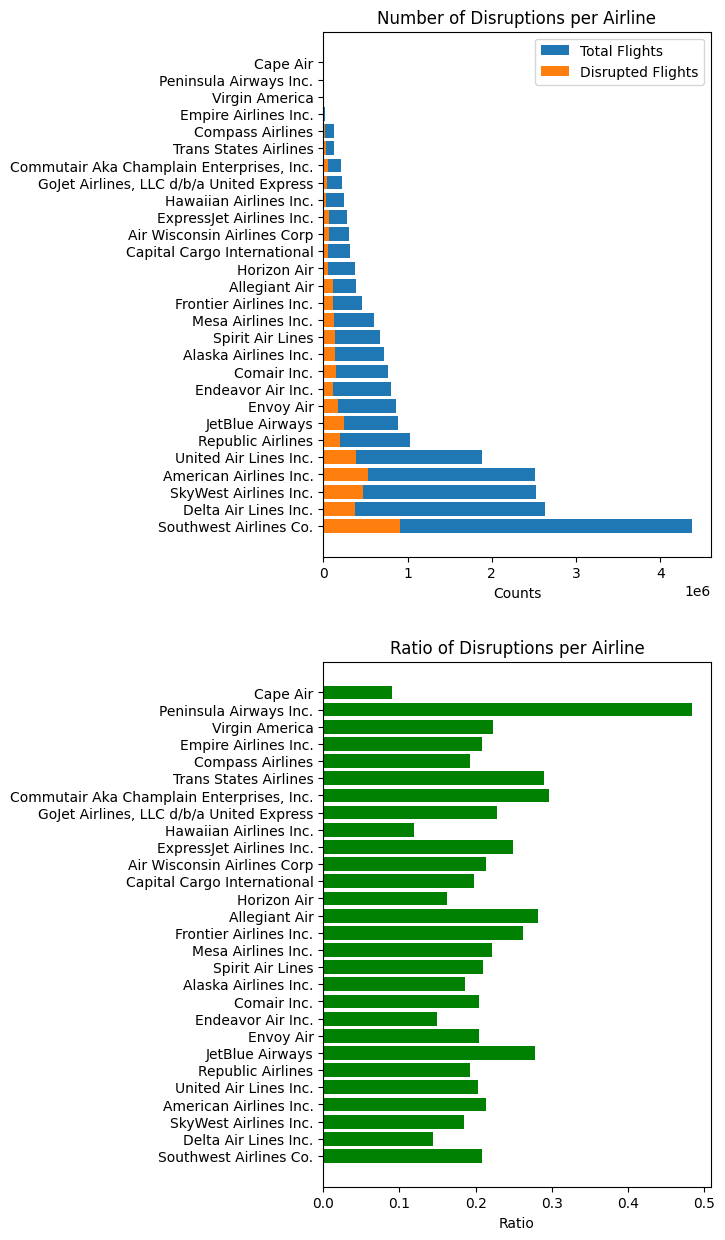

In [84]:
#Chi-square test
crosstab = pd.crosstab(flights_raw['Airline'],flights_raw['Disruption'])
chi2, p, dof, expexcted = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})



airline_data = pd.merge(flights_raw['Airline'].value_counts(),flights_raw.groupby('Airline')['Disruption'].sum(),left_index=True, right_index=True)
airline_data.columns = ["Flights","Disruptions"]
airline_data['Ratio'] = airline_data['Disruptions']/airline_data['Flights']

fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(5,15))
ax1.barh(airline_data.index, airline_data['Flights'],label='Total Flights')
ax1.barh(airline_data.index, airline_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions per Airline')
ax1.set_xlabel('Counts')
ax1.legend()


ax2.barh(airline_data.index, airline_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions per Airline')
ax2.set_xlabel('Ratio')
display(chi2_results);

In [85]:
airline_data.loc['Peninsula Airways Inc.']

Flights        2219.000000
Disruptions    1075.000000
Ratio             0.484452
Name: Peninsula Airways Inc., dtype: float64

As expected the feature `'Airline'` seems to be a good predicter for a disruption. The rate of disruptions varies noticably between airlines and the chi-squared contingency test gives a p-value of about 0, meaning we conclude a relationship between `'Airline'` and `'Disruption'`. We notice that the airline 'Peninsula Airways Inc.' stands out as an outlier with a rate of disruption of 0.47695. We only have 564 observations of this airline so we expect there to be more variability in this ratio. We have other airlines with a low frequency in the data that have significantly lower rates of disruption. There doesn't seem to be a reasonable way to group airlines to reduce the number of unique categories, and since there is no logical order to the airlines, label encoding would not make sense as a method of encoding this feature. Even though 28 is quite a high number of unique categories for one-hot encoding, we will proceed with this method as this seems to be an important feature to include in the model.

### Year, Month, Quarter

,Variable,Year,Quarter,Month
0,Chi-square,97675.431367,34293.951703,104452.466686
1,p-value,0.000000,0.000000,0.000000
2,Degrees of Freedom,4.000000,3.000000,11.000000


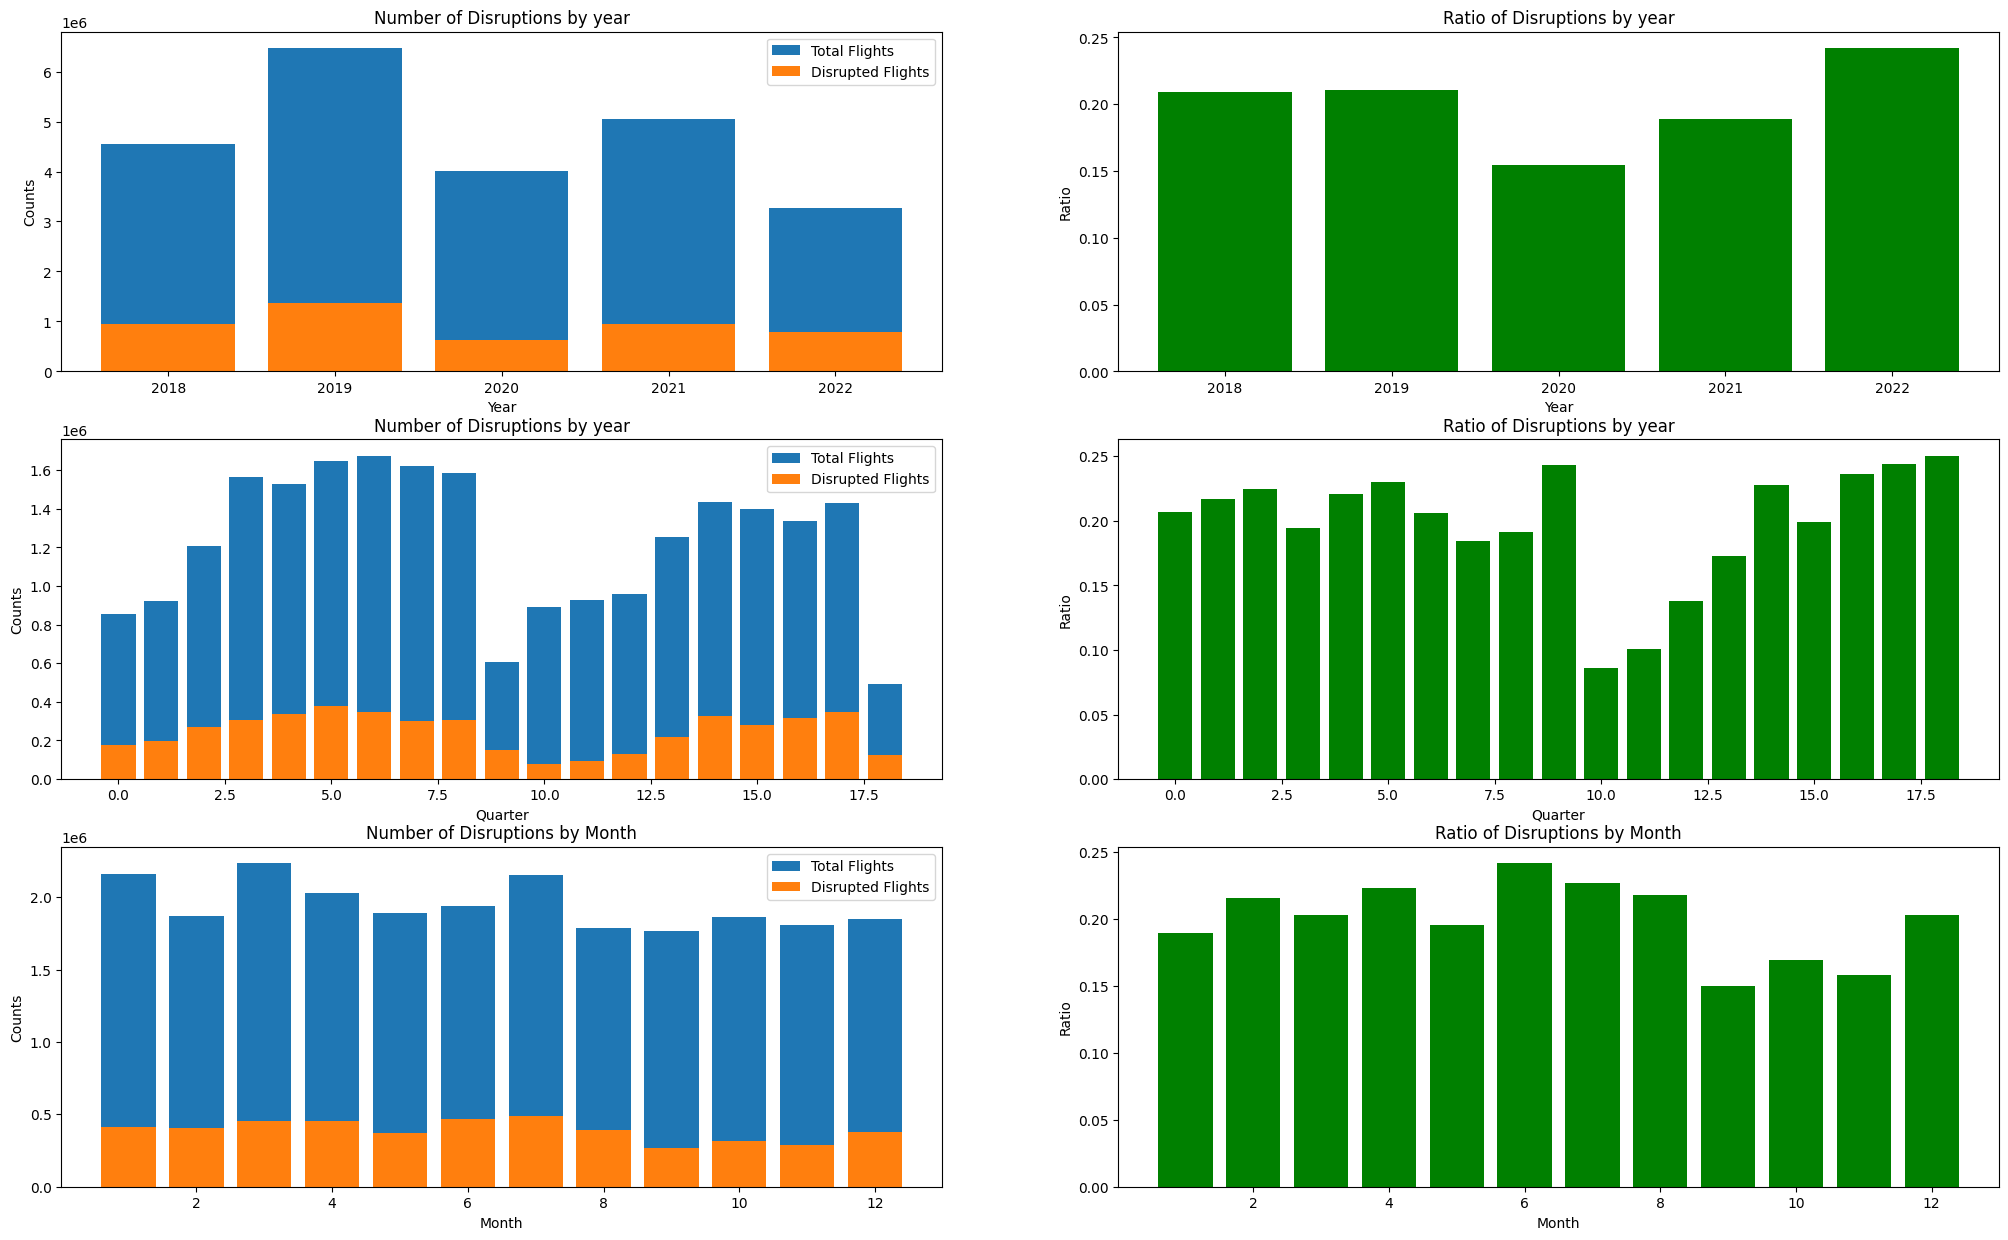

In [86]:
#Conduct chi-squared contingency test for features
chi2_year, p_year, dof_year, expected = chi2_contingency(pd.crosstab(flights_raw['Year'],flights_raw['Disruption']))
chi2_quarter, p_quarter, dof_quarter, expected = chi2_contingency(pd.crosstab(flights_raw['Quarter'],flights_raw['Disruption']))
chi2_month, p_month, dof_month, expected = chi2_contingency(pd.crosstab(flights_raw['Month'],flights_raw['Disruption']))
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Year': [chi2_year, p_year, dof_year],
    'Quarter': [chi2_quarter, p_quarter, dof_quarter],
    'Month': [chi2_month, p_month, dof_month]
})

#Calculate yearly data for plot
year_data = pd.merge(flights_raw['Year'].value_counts(),flights_raw.groupby('Year')['Disruption'].sum(),left_index=True, right_index=True)
year_data.columns = ["Flights","Disruptions"]
year_data['Ratio'] = year_data['Disruptions']/year_data['Flights']

#Calculate quartely
quarter_data = pd.merge(flights_raw.groupby(['Year','Quarter']).size().reset_index(name='Flights'),
         flights_raw.groupby(['Year','Quarter'])['Disruption'].sum().reset_index(name='Disruptions'),
         left_index=True, right_index=True)
quarter_data['Ratio'] = quarter_data['Disruptions']/quarter_data['Flights']

#Calculate monthly data
month_data = pd.merge(flights_raw['Month'].value_counts(),flights_raw.groupby('Month')['Disruption'].sum(),left_index=True, right_index=True)
month_data.columns = ["Flights","Disruptions"]
month_data['Ratio'] = month_data['Disruptions']/month_data['Flights']


fig, ((ax11,ax12),(ax21,ax22),(ax31,ax32)) = plt.subplots(nrows=3,ncols=2,figsize=(25,15))
ax11.bar(year_data.index, year_data['Flights'],label='Total Flights')
ax11.bar(year_data.index, year_data['Disruptions'], label='Disrupted Flights')
ax11.set_title('Number of Disruptions by year')
ax11.set_xlabel('Year')
ax11.set_ylabel('Counts')
ax11.legend()


ax12.bar(year_data.index, year_data['Ratio'],color="green")
ax12.set_title('Ratio of Disruptions by year')
ax12.set_xlabel('Year')
ax12.set_ylabel('Ratio')

ax21.bar(quarter_data.index, quarter_data['Flights'],label='Total Flights')
ax21.bar(quarter_data.index, quarter_data['Disruptions'], label='Disrupted Flights')
ax21.set_title('Number of Disruptions by year')
ax21.set_xlabel('Quarter')
ax21.set_ylabel('Counts')
ax21.legend()


ax22.bar(quarter_data.index, quarter_data['Ratio'],color="green")
ax22.set_title('Ratio of Disruptions by year')
ax22.set_xlabel('Quarter')
ax22.set_ylabel('Ratio')

ax31.bar(month_data.index, month_data['Flights'],label='Total Flights')
ax31.bar(month_data.index, month_data['Disruptions'], label='Disrupted Flights')
ax31.set_title('Number of Disruptions by Month')
ax31.set_xlabel('Month')
ax31.set_ylabel('Counts')
ax31.legend()


ax32.bar(month_data.index, month_data['Ratio'],color="green")
ax32.set_title('Ratio of Disruptions by Month')
ax32.set_xlabel('Month')
ax32.set_ylabel('Ratio')
display(chi2_results)

### Day of Week, Time of Week

In [ ]:
flights_raw['TimeOfDay'] = flights_raw['CRSDepTime'] // 100

#Chi-square test
crosstab = pd.crosstab(flights_raw['DayOfWeek'],flights_raw['Disruption'])
chi2_day, p_day, dof_day, expected = chi2_contingency(crosstab)
crosstab = pd.crosstab(flights_raw['TimeOfDay'],flights_raw['Disruption'])
chi2_day_time, p_day_time, dof_day_time, expected = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'DayOfWeek': [chi2_day, p_day, dof_day],
    'TimeOfDay': [chi2_time, p_time, dof_time]
})

day_data = pd.merge(flights_raw['DayOfWeek'].value_counts(),
                     flights_raw.groupby('DayOfWeek')['Disruption'].sum(),
                     left_index=True, right_index=True)
day_data.columns = ["Flights","Disruptions"]
day_data['Ratio'] = time_data['Disruptions']/time_data['Flights']


time_data = pd.merge(flights_raw['TimeOfDay'].value_counts(),
                     flights_raw.groupby('TimeOfDay')['Disruption'].sum(),
                     left_index=True, right_index=True)
time_data.columns = ["Flights","Disruptions"]
time_data['Ratio'] = time_data['Disruptions']/time_data['Flights']

fig, ((ax11,ax12),(ax21,ax22)) = plt.subplots(nrows=2,ncols=2,figsize=(10,5))

ax11.bar(day_data.index, day_data['Flights'],label='Total Flights')
ax11.bar(day_data.index, day_data['Disruptions'], label='Disrupted Flights')
ax11.set_title('Number of Disruptions by Day of Week')
ax11.set_xlabel('Day of Week')
ax11.set_ylabel('Counts')
ax11.legend()


ax12.bar(time_data.index, time_data['Ratio'],color="green")
ax12.set_title('Ratio of Disruptions by Day of Week')
ax12.set_xlabel('Day of Week')
ax12.set_ylabel('Ratio')


ax21.bar(time_data.index, time_data['Flights'],label='Total Flights')
ax21.bar(time_data.index, time_data['Disruptions'], label='Disrupted Flights')
ax21.set_title('Number of Disruptions by time of day')
ax21.set_xlabel('Time of Day')
ax21.set_ylabel('Counts')
ax21.legend()


ax22.bar(time_data.index, time_data['Ratio'],color="green")
ax22.set_title('Ratio of Disruptions by time of day')
ax22.set_xlabel('Time of Day')
ax22.set_ylabel('Ratio')

display(chi2_results)

### Origin Airport and Destination Airport 

### Distance

### Summary

## Feature Engineering and Preprocessing

In [91]:
#Drop missing values
flights = flights_raw.dropna()

#Make 'TimeOfDay' column
flights['TimeOfDay'] = flights['CRSDepTime'] // 100

#Modify 'Quarter' column to be unique for each year
flights['Quarter'] = flights_raw['Year'].astype(str) + '_Q' + flights_raw['Quarter'].astype(str)
flights['Quarter'] = pd.Categorical(flights['Quarter'])
flights['Quarter'] = flights['Quarter'].cat.codes + 1

#List of features to include in our model
features = ['Airline', 'Origin', 'Quarter', 'TimeOfDay', 'Disruption']

#Group features by how we will encode them
cyclical_encode_features = ['TimeOfDay']
target_encode_features = ['Origin', 'Quarter']
one_hot_encode_features = ['Airline']

#Define a custom encoder for the 'TimeOfDay' feature. This will preserve distances between times of day.
class CyclicalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['Time_sin'] = np.sin(2 * np.pi * X_transformed['TimeOfDay'] / 24)
        X_transformed['Time_cos'] = np.cos(2 * np.pi * X_transformed['TimeOfDay'] / 24)
        return X_transformed.drop(['TimeOfDay'], axis=1)
    def fit_transform(self, X, y=None):
        return self.transform(X)

#Define training set and split of labels
# We will use cross-validation and we have a seperate test set so no need to split data
X_train = flights[features].drop('Disruption', axis = 1)
y_train = flights['Disruption']


#Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), one_hot_encode_features),
        ('target_encode', TargetEncoder(), target_encode_features),
        ('cyclical', CyclicalTransformer(), cyclical_encode_features),
    ],
    remainder='passthrough'
)

/tmp/ipykernel_52263/482244155.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights['TimeOfDay'] = flights['CRSDepTime'] // 100
/tmp/ipykernel_52263/482244155.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights['Quarter'] = flights_raw['Year'].astype(str) + '_Q' + flights_raw['Quarter'].astype(str)
/tmp/ipykernel_52263/482244155.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

### Model Training and Hyperparameter Tuning

### Load Test Data

In [96]:
def import_large(path, features, features_index):   
    data = pd.read_csv(path)
    data.reset_index(inplace=True)
    data = data.iloc[:,features_index]
    data.columns = features
    return data
    
path_to_data = '/cs/datasets/ID5059/Coursework1/4_huge/'
test_csv_names = ['Combined_Flights_test_2018.csv',
                  'Combined_Flights_test_2019.csv',
                  'Combined_Flights_test_2020.csv',
                  'Combined_Flights_test_2021.csv',
                  'Combined_Flights_test_2022.csv'] 
data = []
for csv_name in test_csv_names:
    full_path = path_to_data + csv_name
    year_data = import_large(full_path,['Airline','Origin', 'Dest','CRSDepTime','Distance', 'Year','Quarter', 'Month','DayOfWeek','Disruption'],features_index)
    data.append(year_data)
flights_test = pd.concat(data,ignore_index=True)
flights_test = flights_test.dropna()

#Make 'TimeOfDay' column
flights_test['TimeOfDay'] = flights_test['CRSDepTime'] // 100

#Modify 'Quarter' column to be unique for each year
flights_test['Quarter'] = flights_test['Year'].astype(str) + '_Q' + flights_test['Quarter'].astype(str)
flights_test['Quarter'] = pd.Categorical(flights_test['Quarter'])
flights_test['Quarter'] = flights_test['Quarter'].cat.codes + 1

flights_test = flights_test.loc[:,features]
X_test = flights_test[features].drop('Disruption', axis = 1)
y_test = flights_test['Disruption']

### Model 1: Stochastic Gradient Descent 

In [40]:
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(loss = 'log_loss'))
])

#flights_gscv_subsample  = flights.sample(n=100000, random_state=17)
flights_gscv_subsample = flights

X_subsample = flights_gscv_subsample[features].drop('Disruption', axis = 1)
y_subsample = flights_gscv_subsample['Disruption']

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__alpha': [0.00001,0.0001, 0.001, 0.01],
    'classifier__max_iter': [500,1000, 2000, 3000],
}

grid_search = GridSearchCV(estimator=sgd_pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_subsample, y_subsample)

best_params_sgd, best_score_sgd = grid_search.best_params_, grid_search.best_score_
best_params_sgd, best_score_sgd

/cs/home/slh27/Documents/ID5059Project1/myenvID5059/lib64/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


({'classifier__alpha': 0.0001,
  'classifier__max_iter': 1000,
  'classifier__penalty': 'l1'},
 0.7995263960713981)

In [89]:
sgd_pipeline.set_params(**best_params_sgd)
sgd_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Airline']),
                                                 ('target_encode',
                                                  TargetEncoder(),
                                                  ['Origin', 'Quarter']),
                                                 ('cyclical',
                                                  CyclicalTransformer(),
                                                  ['TimeOfDay'])])),
                ('classifier', SGDClassifier(loss='log_loss', penalty='l1'))])

Precision: 0.0
Recall: 0.0
f1-score: nan
Accuracy: 0.7995260535255335


/tmp/ipykernel_52263/3475424941.py:6: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2*precision*recall/(precision+recall)


<Axes: >

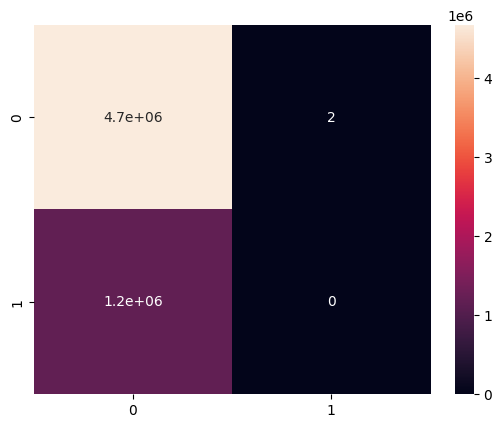

In [97]:
y_scores_sgd = sgd_pipeline.predict_proba(X_test)
y_pred_sgd = np.where(y_scores_sgd[:,1]>0.5,1,0)
conf_mat = confusion_matrix(y_test, y_pred_sgd)
precision = conf_mat[1,1]/sum(conf_mat[:,1]) if sum(conf_mat[:,1])>0 else 'Undefined'
recall = conf_mat[1,1]/sum(conf_mat[1,:]) if sum(conf_mat[1,:])>0 else 'Undefined'
f1_score = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 'Undefined'
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
sns.heatmap(conf_mat, annot=True)